# <span style="color:darkblue"> Laboratorio di Simulazione Numerica </span>
#### <span style="color:darkred">  Riccardo Beccaria - Luglio 2021</span>

# <span style="color:green"> Esercitazione 4<span>

Nel corso di questa esercitazione ho simulato delle particelle di Argon attraverso dinamica molecolare. Ho compiuto diverse simulazioni a diverse fasi dell'Argon: liquida, solida e gassosa. Ho mantenuto invece inalterate le seguenti proprietà: 108 Numero particelle simulate, 50 blocchi per utilizzare il metodo di Data Blocking e infine 500 misure per ogni blocco.

### Esercizio 04.1

The Molecular Dynamics (MD) code starts the simulation run from a provided spatial configuration of the $N$ particles (<font face="Courier">config.0</font>) and, once the simulation is finished, it writes out the final configuration (file: <font face="Courier">config.final</font>). 
1. Improve the MD code by enabling (you should insert this option via a boolean-like variable in the input file) the possibility to (re)start reading not only a actual spatial configuration [$\vec{r}(t)$] file but also an old spatial configuration [$\vec{r}(t-dt)$] file</span> (files: <font face="Courier">old.0</font> and <font face="Courier">old.final</font>).
2. Moreover, add the possibility to rescale the velocities [i.e. to correct $\vec{r}(t-dt)$] in order to match a desired temperature.
3. In your report, put some pictures which show that you have been able to equilibrate the thermodynamic phases at the beginning of your simulations.

Il codice di Dinamica Molecolare, così come mi è stato fornito inizialmente, non contempla l'ipotesi di ripartenza da due configurazioni. L'unica opzione che contempla, è quella in cui viene fornita una singola configurazione iniziale; si generano casualmente delle velocità (opportunamente riscalate per avvicinarsi alla temperatura target); dalla configurazione iniziale, conoscendo le velocità si genera una nuova conformazione; dalla conformazione iniziale e da quest'ultima appena generata inizia la Dinamica Molecolare con l'algoritmo di Verlet.

Nelle prima parte dell'esercitazione ho quindi implementato la possibilità di ripartenza da due configurazioni iniziali salvate al termine di una precedente simulazione. Ho quindi due file di input:  <font face="Courier">config.final</font> contenente la conformazione $\vec{r}(t)$, e un secondo file <font face="Courier">config.pre_final</font> contenente invece la conformazione $\vec{r}(t-dt)$. Conoscendo queste due conformazioni quello che ho fatto è stato:

1. Conoscendo $\vec{r}(t)$ e $\vec{r}(t-dt)$, ho calcolato $\vec{v}(t- \frac{dt}{2})=\frac{\vec{r}(t)-\vec{r}(t-dt)}{2}$ per ogni particella del sistema.
2. Ho calcolato la temperatura del sistema grazie al principio di equipartizione come:  $T=\frac{\sum v_i^2}{3 N_{part}}$.
3. Conoscendo la temperatura istantanea ho potuto calcolare il fattore di riscalamento delle velocità come: $f_s=\sqrt{\frac{T^*}{T}}$ dove $T^*$ è la temperatura target che voglio raggiungere.
4. Ho riscalato le velocità $\vec{v}(t- \frac{dt}{2})$ tramite il fattore di riscalamento $f_s$ così da avere $\vec{v} \rightarrow \vec{v}_s$ 
5. Conoscendo le nuove velocità ho potuto calcolare le nuove coordinate al tempo t come: $\vec{r}_{new}(t-dt)= \vec{r}(t) - dt \cdot \vec{v}_s$ 
6. Conoscendo queste due conformazioni $\vec{r}_{new}(t-dt)$ e $\vec{r}(t)$, ho potuto iniziare la simulazione di dinamica molecolare con l'algoritmo di Verlet.


Il motivo di questa implementazione è dato dal fatto che l'<font color="red"> Algoritmo di Verlet </font> calcola le nuove posizioni come:
    
$$\vec{r}(t+dt) \simeq 2 \vec {r}(t) - \vec{r}(t-dt)+dt^2 \cdot \vec{a}(t)$$

Pertanto questo algoritmo non richiede le velocità! Ma solo due conformazioni del sistema a tempi successivi, e il valore dell'accelerazione. Quest'ultima viene calcolata calcolando inizialmente la somma delle forze che agiscono sulla *i-esima* particella e sfruttando la seconda legge di Newton $\vec{F}=m \vec{a}$.

Questa ripartenza è stata implementata nel codice con l'opzione di eseguirla o di non eseguirla. Nel file di input <font face="Courier">input.dat</font>, è stata aggiunta una nuova variabile `restart`. Quando restart=0, il codice non esegue l'opzione della ripartenza da me implementata. Altrimenti, quando restart=1, il codice esegue l'opzione della ripartenza.

La ripartenza è necessaria per portare il sistema alla temperatura fissata. Infatti quando eseguo dinamica molecolare sul sistema di Argon devo preoccuparmi che la temperatura del sistema sia effetivamente quella target che desidero studiare. Per fare ciò sarà necessario eseguire almeno 5 o 6 ripartenze per la fase liquida e solida, mentre saranno necessarie un numero minore di ripartenze per la fase gassosa. Ho riportato nella parte finale di questo report i grafici che mostrano l'equilibrazione del sistema con l'opzione da me implementata.

### Esercizio 04.2

The Molecular Dynamics code we have provided prints out only instantaneous values for the total (internal) energy per particle, $E/N$, potential energy per particle, $U/N$, kinetic energy per particle, $K/N$, and temperature, $T$.
Take the MD code and include block averaging: 

Divide the <font face="Courier">nstep</font> of the simulation into <font face="Courier">nblocks</font>. By exploiting these blocks, code the calculation of the average values and the uncertainties for $E/N$, $U/N$, $K/N$ and $T$, that will be written in new specific output files, for example: <font face="Courier">ave_epot.out, ave_ekin.out, ave_etot.out, ave_temp.out</font></span>

Nel codice di Dinamica Molecolare ho implementato la possibilità di calcolare i valori medi delle proprietà termodinamiche studiate attraverso Data Blocking. Le misure di queste proprietà termodinamiche non avviene ad ogni passo della simulazione, ma ogni 10. Il motivo di questa scelta è per due ragioni. La prima è per non riempire il computer con dei file troppo grandi. Il secondo motivo è perchè configurazioni troppo vicine tra loro possono portare informazione ridondante sul calcolo dell quantità termodinamiche. La media a blocchi è avvenuta seguendo questo schema:
1. All'inizio di ogni blocco vengono resettate tramite la funzione <font face="Courier">Reset(iblk)</font>, gli indici e gli elementi dei vettori impiegati come appoggio per effettuare la media a blocchi. La quantità <font face="Courier">iblk</font> rappresenta il numero di blocco a cui sono arrivato con la simulazione.
2. Dopo la funzione <font face="Courier">Move()</font> che permette alle particelle di muoversi tramite l'algoritmo di Verlet, viene richiamata la funzione <font face="Courier">Measure()</font> ogni 10 passi della simulazione che misura tutte le proprietà termodinamiche di interesse.
3. Dopo ogni misura viene richiamata la funzione <font face="Courier">Accumulate()</font> per accumulare in un vettore opportuno le misure appena eseguite.
4. Al termine di ogni blocco viene richiamata la funzione <font face="Courier">Averages(iblk)</font> che ha il compito di compiere una media a blocchi tra le misre appena eseguite, e le misure ottenute nei blocchi precedenti.


<font color="red"> N.B. </font> in realtà è stata introdotta una nuova variabile di nome `start_measure` nel file di input <font face="Courier">input.dat</font> per indicare se sono ancora o meno nella fase di equilibrazione. Infatti non ha senso andare a compiere una media a blocchi durante la fase di equilibrazione: eseguirei delle operazioni di calcolo che sarebbero inutili. Pertanto le funzioni <font face="Courier">Accumulate()</font> e <font face="Courier">Averages(iblk)</font> vengono richiamate soltanto se start_measure=1.

### Exercise 04.3

By means of your upgraded MD code, equilibrate and perform MD simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

and show in pictures the obtained average values and uncertainties for the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$ and the temperature, $T$ ... in SI units!

Una volta implementato nel codice la possibilità di ripartenza è il Data Blocking sono state effettuate le simulazioni di Dinamica Molecolare vere e proprie. È stato simulato un sistema di 108 particelle di Argon attraverso un sistema Lennard-Jones: dove cioè le forze sono cacolate tramite un potenziale LJ.
Le informazioni relative alla fase del sistema si comunicano al codice attraverso il file di input <font face="Courier">input.dat</font> in cui oltre alla densità e temperatura del sistema, e oltre al raggio di cut-off utilizzato per il calcolo delle forze, vengono inseriti anche i valori per le due variabili `start_measure` e `restart` presentate nei primi due punti dell'esercitazione.

La prima simulazioni per ognuna delle tre differenti fasi del sistema, è stata lanciata ponendo restart=0 e start_measure=0. Infatti, siccome è la prima volta in cui lancio la simulazione, si ha esclusivamente un'unica configurazione iniziale del sitema: quella contenuta in <font face="Courier">config.0</font>. In questo file è contenuta una configurazione FCC per il sistema. Una volta portata a termine la prima simulazione, ho incominciato la fase di termalizzazione ponendo restart=1 e rilanciando più volte la simulazione fino al punto in cui la temperatura del sistema non fosse prossima alla temperatura target richiesta. Infine, una volta equilibrato correttamente il sistema ho potuto lanciare la simulazione ponendo anche start_measure=1. In questo modo sono state salvate e stampate anche i valori delle proprietà termodinamiche indagate tramite il metodo di Data Blocking.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'


epsilon_kB = 120. #kelvin
kb = 1.380649*(10.**(-23))
epsilon = epsilon_kB*kb

#### FASE SOLIDA

#### Equilibrazione del sistema

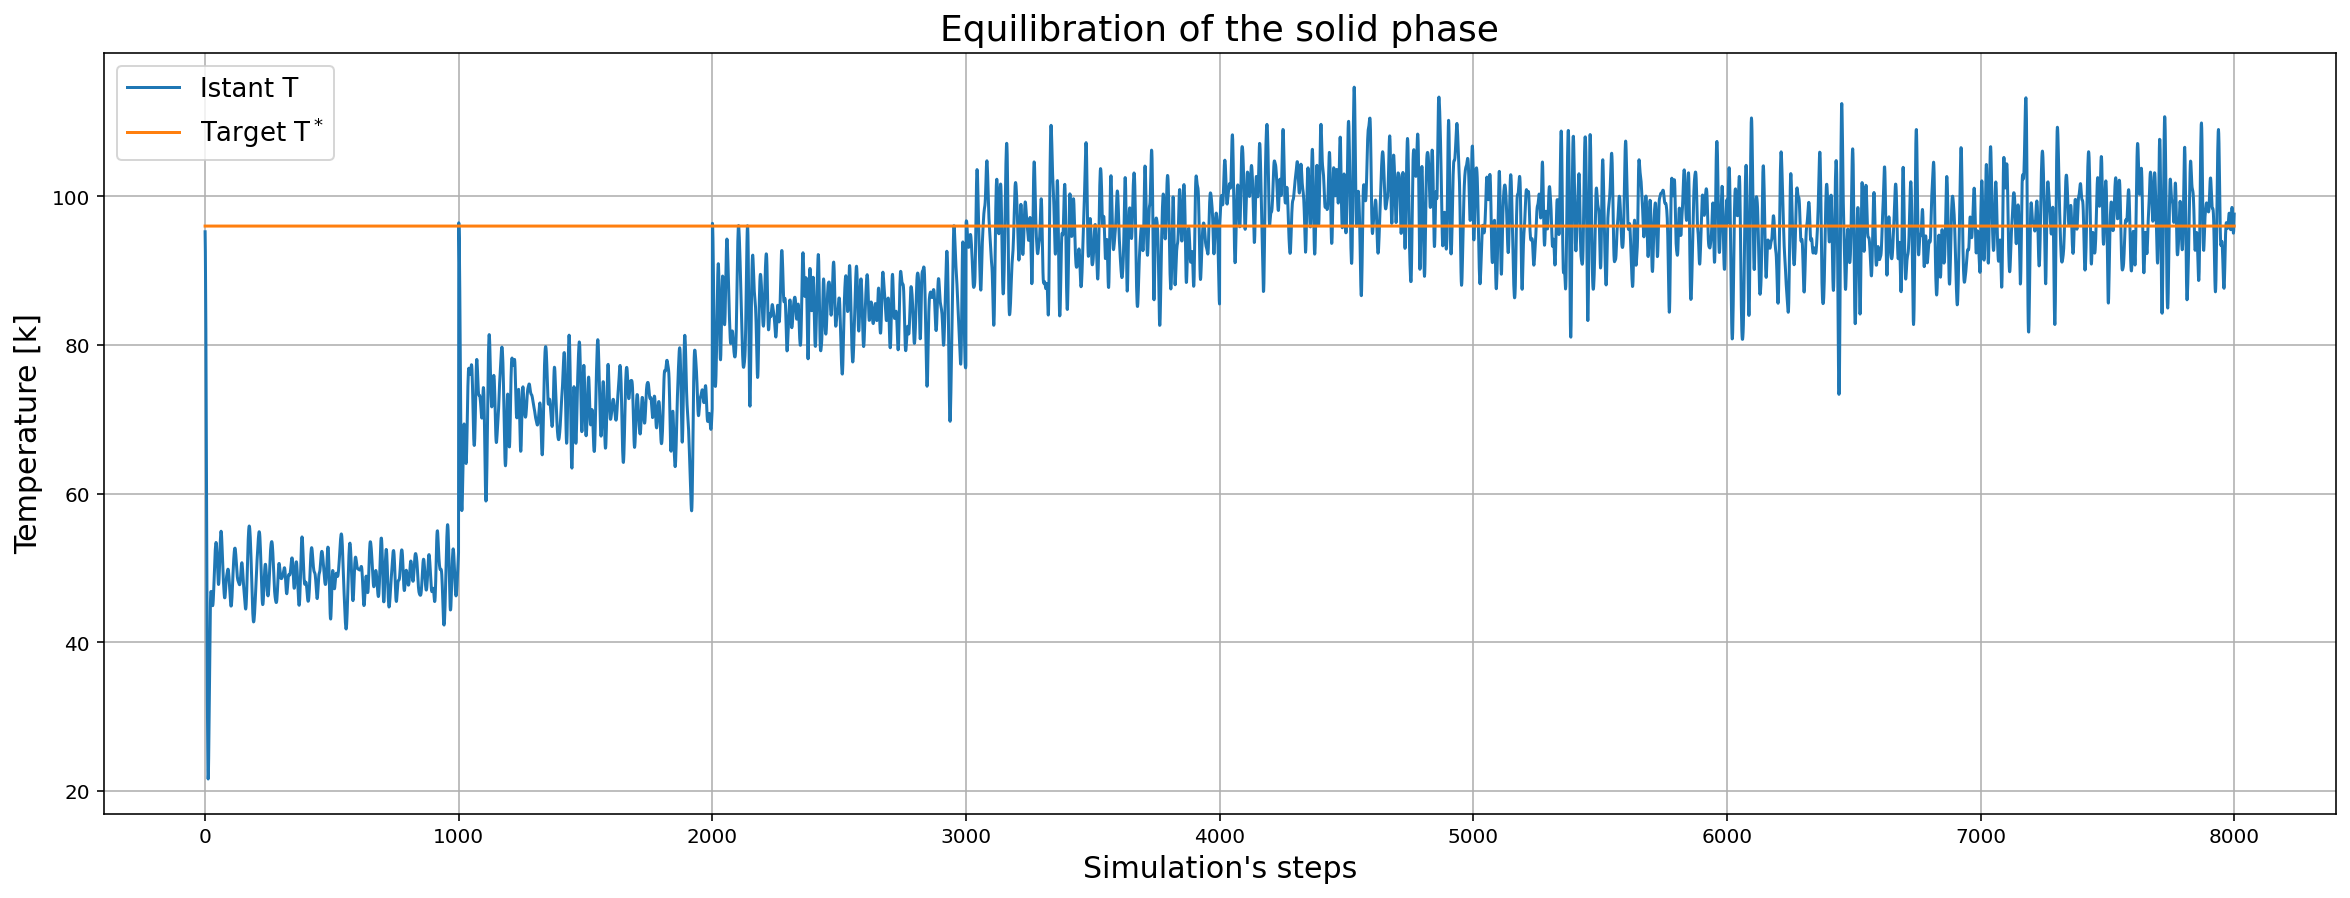

In [22]:
t =epsilon_kB* np.loadtxt("./04.1/MolecularDynamics_NVE/solid_phase/equilibration_solid.dat", usecols=(0), unpack='true')
blk=np.arange(len(t))

L = 8000
Temp=0.8

y=np.full(L, epsilon_kB*Temp)

plt.figure(figsize=(20,7))
plt.plot(blk,t, label='Istant T')
plt.plot(blk,y, label=r'Target T$^*$')
plt.title('Equilibration of the solid phase', fontsize=18)
plt.ylabel('Temperature [k]', fontsize=15)
plt.xlabel("Simulation's steps", fontsize=15)

plt.legend(fontsize=13)
plt.grid()
plt.show()


Quello che si può osservare nella fase di quilibrazione del sistema è di come dopo un primo crollo della temperatura, il sistema ad ogni restart aumenta la temperatura fino a raggiugere quella target richiesta. È evidente come dopo appena 5 ripartenze, il sistema si trovi ben equilibrato alla temperatura desiderata. I salti netti della temperatura possono spiegarsi per via della iniziale stima naif delle coordinate $x_{old}$, $y_{old}$ e $z_{old}$: non appena vengono riscalate le velocità del fattore $f_s$ le conformazioni del sistema, dopo un primo brusco salto per via del riscalamento, tendono a stazionare attorno a un valore, fino a una nuova ripartenza.

Il crollo improvviso al primo step della simulazione si può spiegare col fatto che l'iniziale configurazione del sistema è una configurazione FCC, pertanto è una configurazione in un minimo di energia potenziale. Pertanto, anche piccole oscillazioni da questo minimo, possono causare bruschi aumenti all'energia potenziale e conseguentemente brusche diminuzioni all'energia cinetica e quindi alle velocità. È dal momento che le velocità sono con questa stretta dipendenza dalla temperatura del sistema, si osserva questo improvviso crollo al primo step della simulazione.

#### Misura di proprietà termodinamiche istantanee

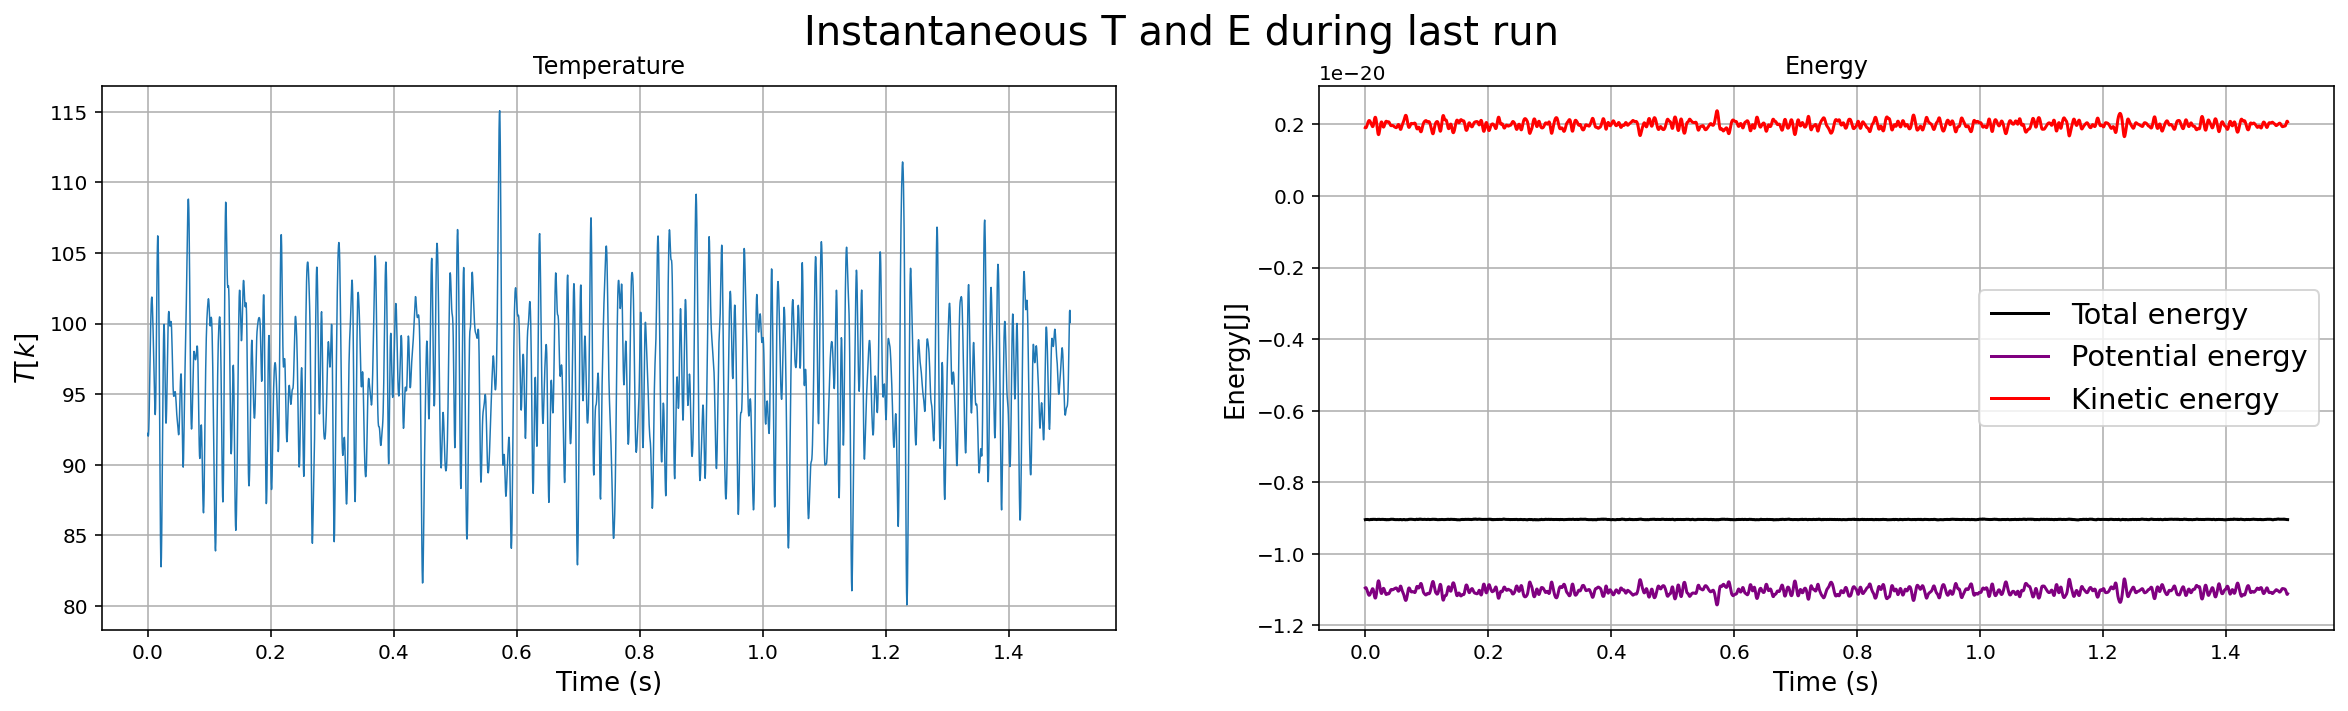

In [23]:
(T_eq) = np.loadtxt('./04.1/MolecularDynamics_NVE/solid_phase/output_temp_solid.dat', unpack=True, usecols=(0), skiprows=15000)
(Etot_eq) = np.loadtxt('./04.1/MolecularDynamics_NVE/solid_phase/output_etot_solid.dat', unpack=True, usecols=(0), skiprows=15000)
(Epot_eq) = np.loadtxt('./04.1/MolecularDynamics_NVE/solid_phase/output_epot_solid.dat', unpack=True, usecols=(0), skiprows=15000)
(Ekin_eq) = np.loadtxt('./04.1/MolecularDynamics_NVE/solid_phase/output_ekin_solid.dat', unpack=True, usecols=(0), skiprows=15000)

fig, axs = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Instantaneous T and E during last run', fontsize=20)

T_eq = T_eq*epsilon_kB #converto in SI units
l_eq = len(T_eq)
x_eq = np.linspace(0, l_eq, l_eq)

axs[0].plot(0.0005*x_eq, T_eq, linewidth=0.75)
axs[0].set_ylabel('$T[k]$', fontsize=13)
axs[0].set_title("Temperature")

axs[1].set_title("Energy")
axs[1].plot(0.0005*x_eq, Etot_eq*epsilon, label='Total energy', color='black')
axs[1].plot(0.0005*x_eq, Epot_eq*epsilon, label='Potential energy', color='purple')
axs[1].plot(0.0005*x_eq, Ekin_eq*epsilon, label='Kinetic energy', color='red')
axs[1].set_ylabel('Energy[J]', fontsize=13)
axs[1].legend(fontsize='x-large')

for ax in axs.flat:
    ax.set_xlabel('Time (s)', fontsize=13)
    ax.grid()

Ho riportato qui sopra i grafici istantanei di temperatura ed energia dell'ultima simulazione eseguita ovvero di quella in cui ho messo la variabile start_measure=1. Da una parte si può vedere come le fluttuazioni di temperatura siano comunque attorno al valore target della temperatura del sistema. Nel secondo grafico invece è evidente come oscillazioni dell'energia cinetica e potenziale non comportino variazioni sull'energia totale: questo mostra come l'algoritmo di Verlet conserva l'energia su scale temporali elevate.

#### Misura delle proprietà termodinamiche a blocchi

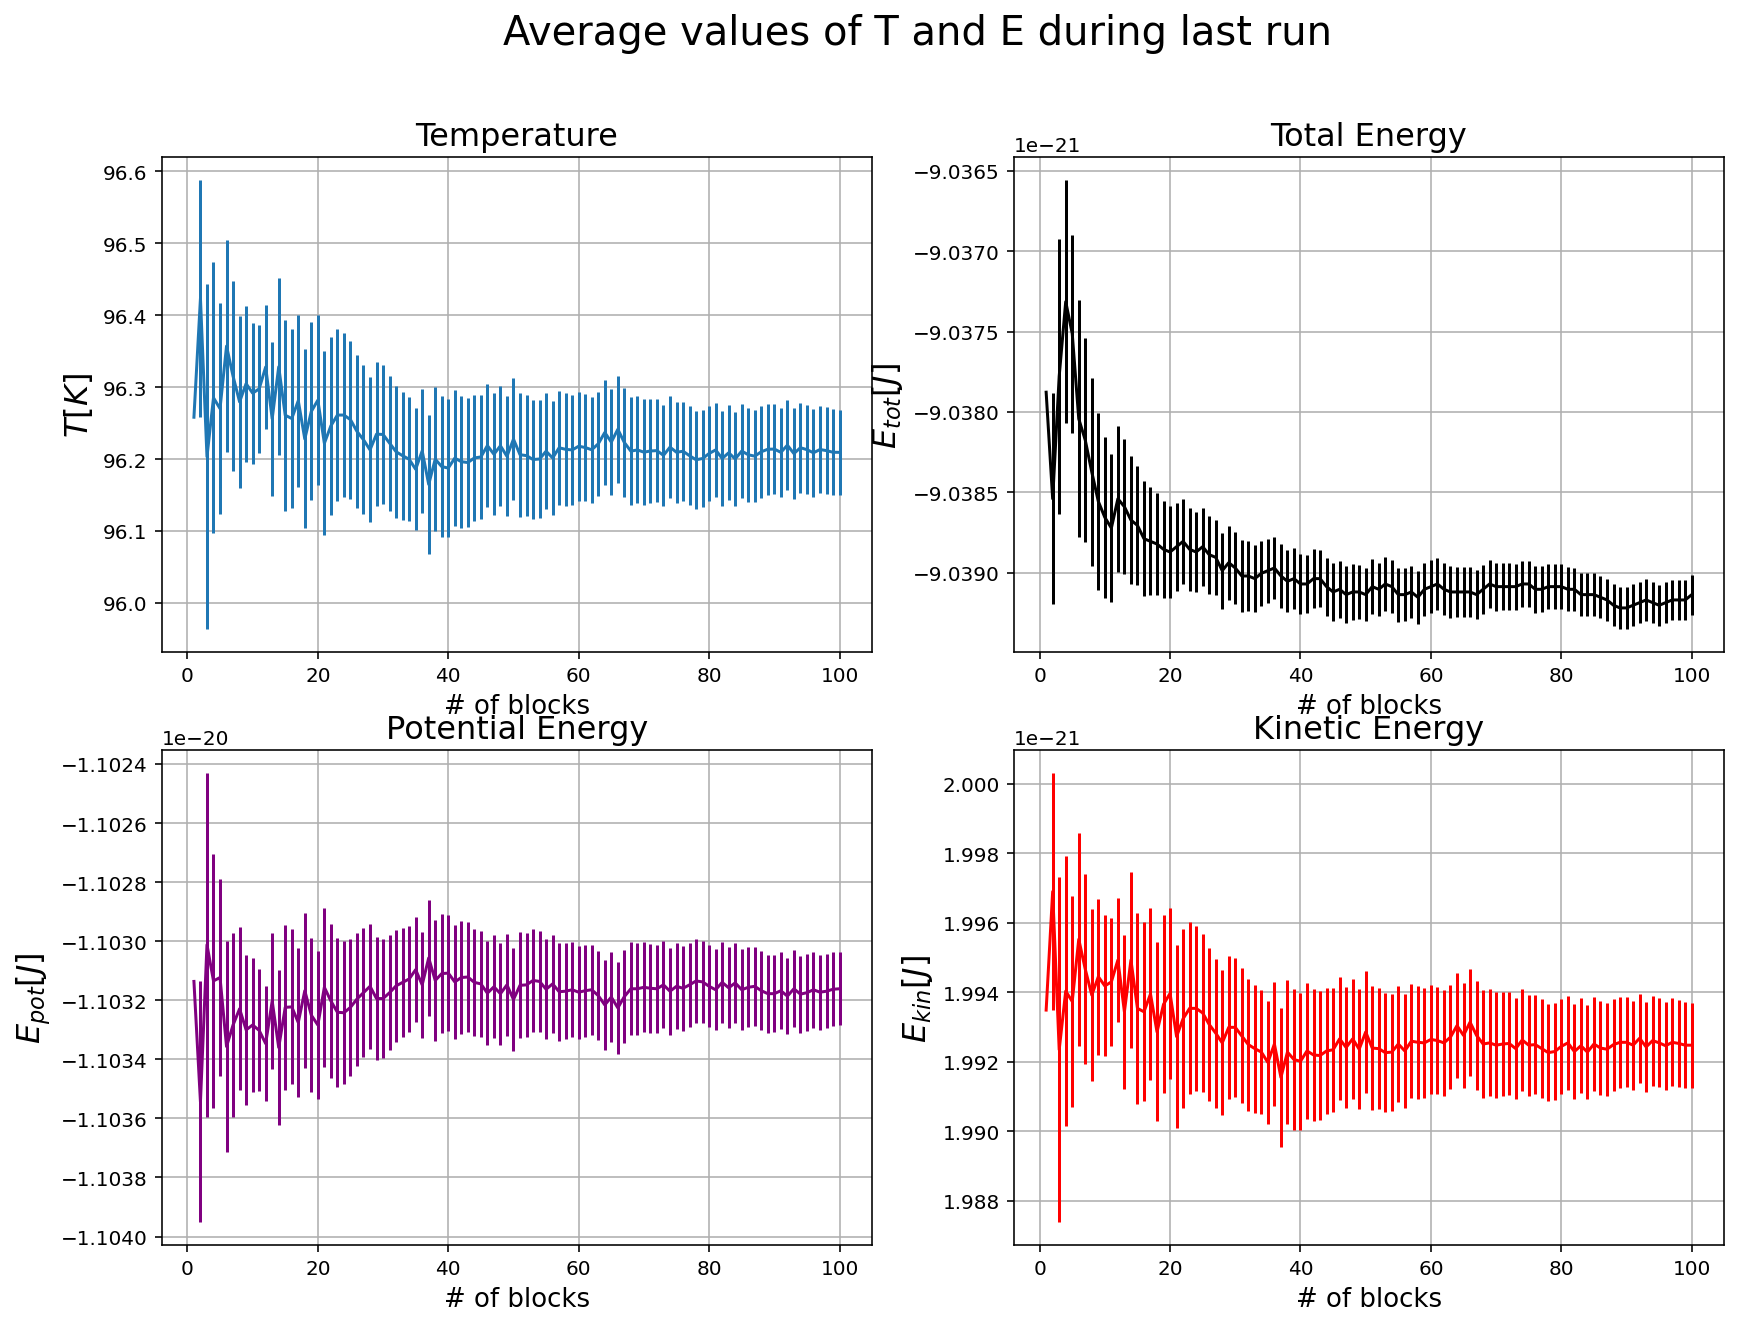

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))

(blk, Ekin, errEkin) = np.loadtxt('./04.1/MolecularDynamics_NVE/solid_phase/ave_kin_solid.out', unpack=True, usecols=(0,2,3))
Ekin = Ekin*epsilon
errEkin = errEkin*epsilon

(Epot, errEpot) = np.loadtxt('./04.1/MolecularDynamics_NVE/solid_phase/ave_epot_solid.out', unpack=True, usecols=(2,3))
Epot = Epot*epsilon
errEpot = errEpot*epsilon

(Etot, errEtot) = np.loadtxt('./04.1/MolecularDynamics_NVE/solid_phase/ave_etot_solid.out', unpack=True, usecols=(2,3))
Etot = Etot*epsilon
errEtot = errEtot*epsilon

(T, errT) = np.loadtxt('./04.1/MolecularDynamics_NVE/solid_phase/ave_temp_solid.out', unpack=True, usecols=(2,3))
T = T*epsilon_kB #SI units!!
errT = errT*epsilon_kB # also for the errors...

plt.suptitle('Average values of T and E during last run', fontsize=20)

# Temperatura
axs[0,0].set_title("Temperature", fontsize=16)
axs[0,0].errorbar(blk, T, yerr=errT, label='Temperature')
axs[0,0].set_ylabel('$T[K]$', fontsize=16)
#axs[0,0].legend(loc=1, fontsize='large')

# Energia Totale
axs[0,1].set_title("Total Energy", fontsize=16)
axs[0,1].errorbar(blk, Etot, yerr=errEtot, label='Energia totale', color='black')
axs[0,1].set_ylabel('$E_{tot}[J]$', fontsize=16)
#axs[0,1].legend(loc=1, fontsize='large')

# Energia potenziale
axs[1,0].set_title("Potential Energy", fontsize=16)
axs[1,0].errorbar(blk, Epot, yerr=errEpot, label='Energia potenziale', color='purple')
axs[1,0].set_ylabel('$E_{pot}[J]$', fontsize=16)
#axs[1,0].legend(loc=1, fontsize='large')

# Energia cinetica
axs[1,1].set_title("Kinetic Energy", fontsize=16)
axs[1,1].errorbar(blk, Ekin, yerr=errEkin, label='Energia cinetica', color='red')
axs[1,1].set_ylabel('$E_{kin} [J]$', fontsize=16)
#axs[1,1].legend(loc=1, fontsize='large')

for ax in axs.flat:
    ax.set_xlabel('# of blocks', fontsize=13)
    ax.grid()

Ho da ultimo riportato gli andamenti di Temperatura, Energia cinetica, potenziale e totale, ottenute tramite media a blocchi. Anche in questo caso è possibile osservare che con l'aumentare del numero di blocchi il valore di queste proprietà termodinamiche si stabilizzi attorno a un valore medio, e che le barre di errore diminuiscono con l'aumentare del numero di blocchi con cui ho condotto la simulazione.

#### FASE LIQUIDA

La simulazione della fase liquida non è troppo differente dalla simulazione della fase solida. L'equilibrazione avviene dopo appena 4 ripartenze. Per il resto il comportamento delle proprietà termodinamiche istantanee e ottenute tramite Data Blocking rispecchia gli andamenti osservati nella fase solida. Valgono quindi tutte le considerazione fatte anche rigurardo la fase di equilibrazione.

#### Equilibrazione

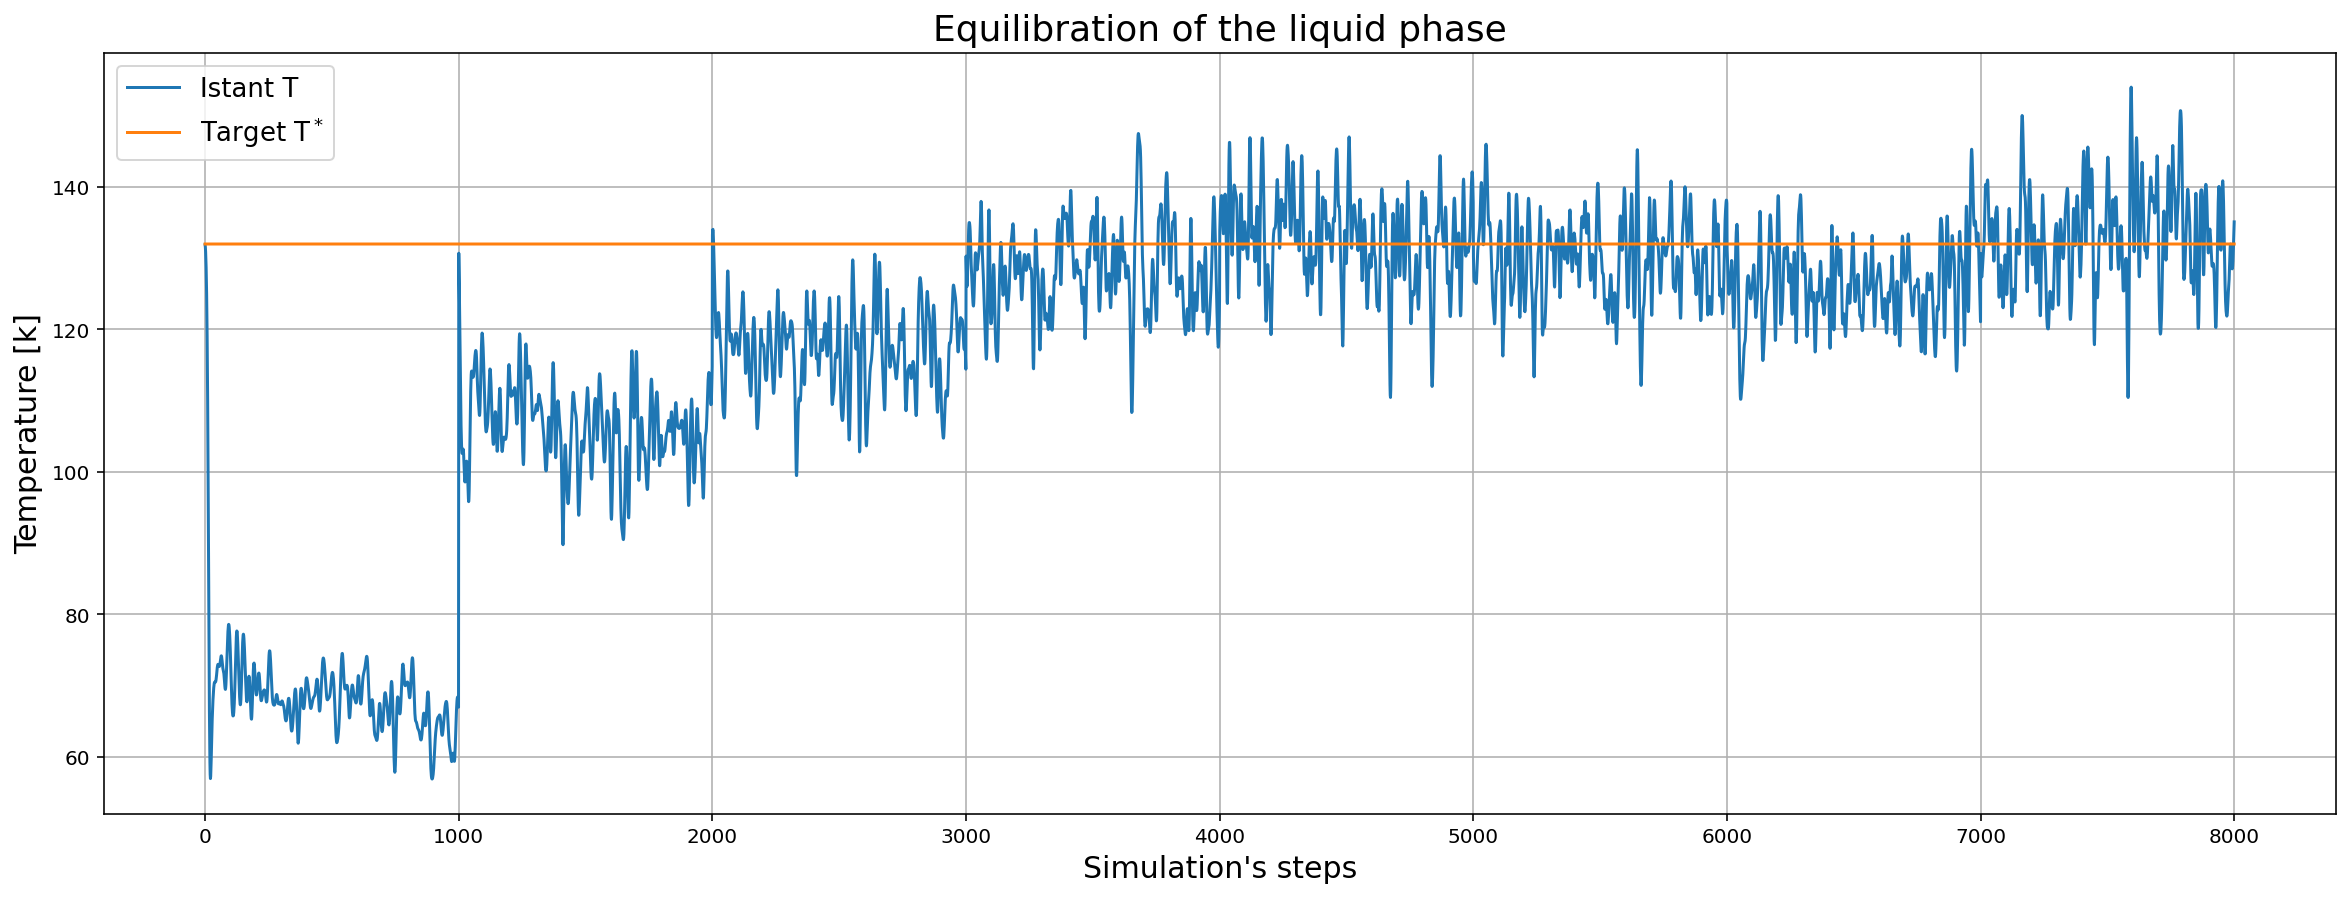

In [17]:
target_T= 1.1 *epsilon_kB
t = epsilon_kB*np.loadtxt("./04.1/MolecularDynamics_NVE/liquid_phase/equilibration_liquid.dat", usecols=(0), unpack='true')
blk=np.arange(len(t))
L = 8000
Temp=1.1*epsilon_kB

x = np.arange(L)
y=np.full(L, Temp)

plt.figure(figsize=(20,7))
plt.plot(blk,t, label='Istant T')
plt.plot(blk,y, label=r'Target T$^*$')
plt.title('Equilibration of the liquid phase', fontsize=18)
plt.ylabel('Temperature [k]', fontsize=15)
plt.xlabel("Simulation's steps", fontsize=15)

plt.legend(fontsize=13)
plt.grid()
plt.show()

#### Misura delle proprietà istantanee

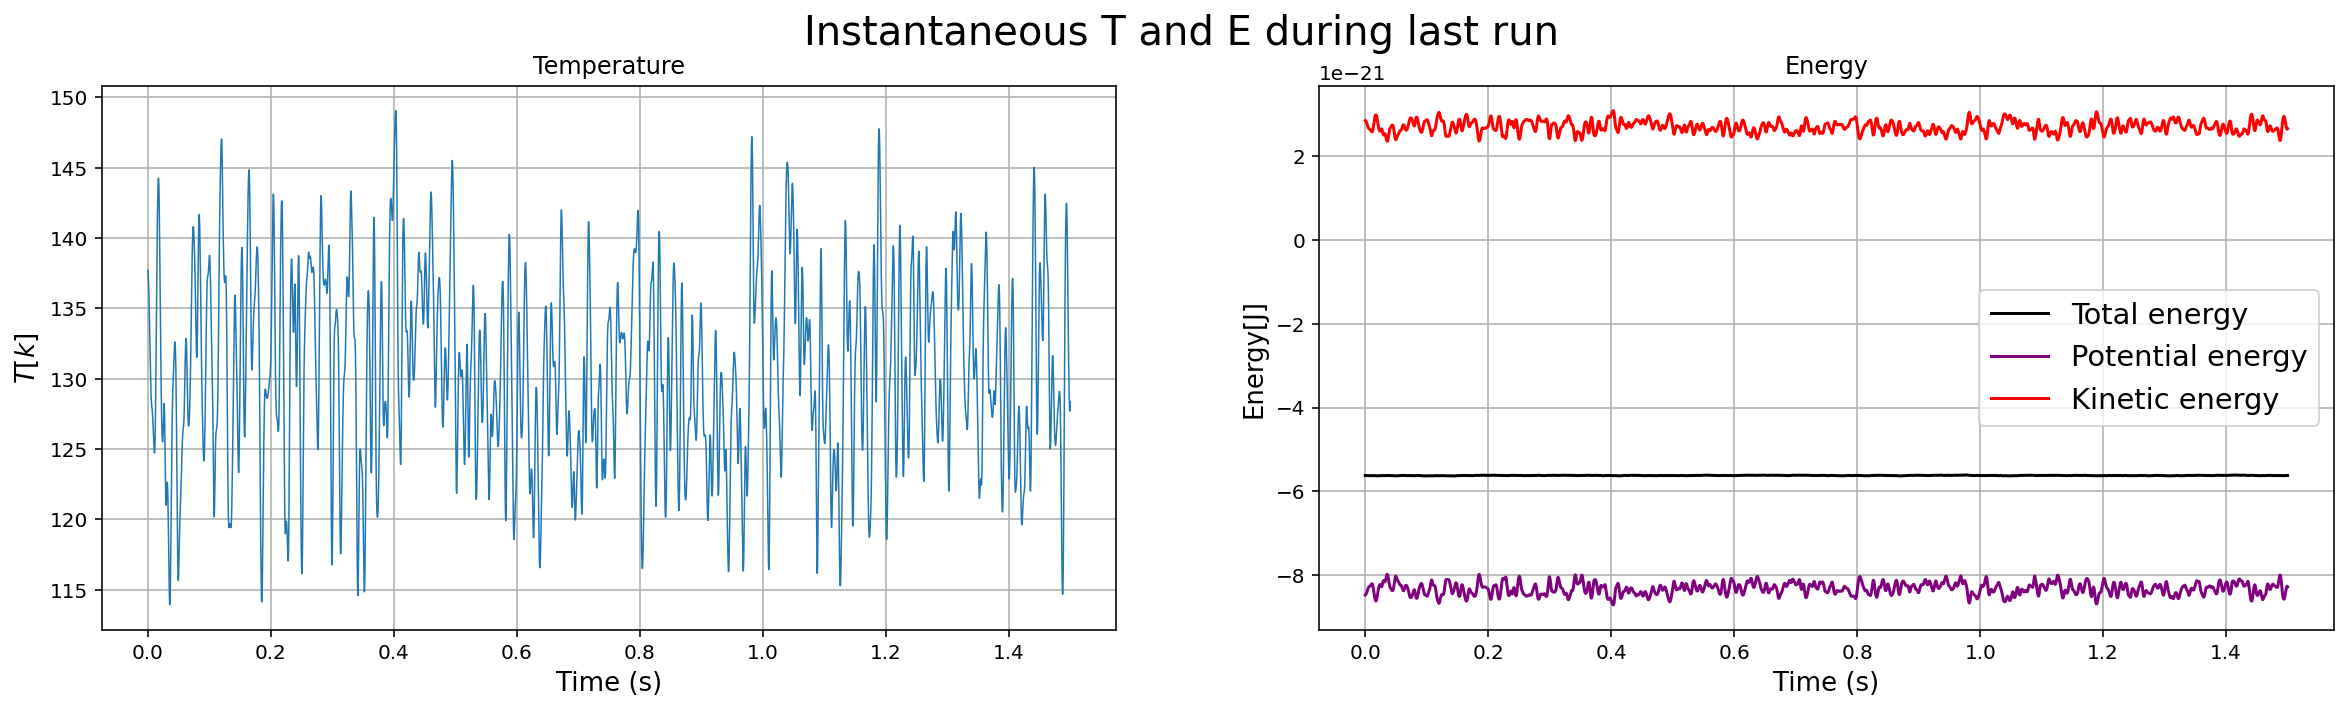

In [19]:
(T_eq) = np.loadtxt('./04.1/MolecularDynamics_NVE/liquid_phase/output_temp_liquid.dat', unpack=True, usecols=(0), skiprows=15000)
(Etot_eq) = np.loadtxt('./04.1/MolecularDynamics_NVE/liquid_phase/output_etot_liquid.dat', unpack=True, usecols=(0), skiprows=15000)
(Epot_eq) = np.loadtxt('./04.1/MolecularDynamics_NVE/liquid_phase/output_epot_liquid.dat', unpack=True, usecols=(0), skiprows=15000)
(Ekin_eq) = np.loadtxt('./04.1/MolecularDynamics_NVE/liquid_phase/output_ekin_liquid.dat', unpack=True, usecols=(0), skiprows=15000)

fig, axs = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Instantaneous T and E during last run', fontsize=20)

T_eq = T_eq*epsilon_kB #converto in SI units
l_eq = len(T_eq)
x_eq = np.linspace(0, l_eq, l_eq)

axs[0].plot(0.0005*x_eq, T_eq, linewidth=0.75)
axs[0].set_ylabel('$T[k]$', fontsize=13)
axs[0].set_title("Temperature")

axs[1].set_title("Energy")
axs[1].plot(0.0005*x_eq, Etot_eq*epsilon, label='Total energy', color='black')
axs[1].plot(0.0005*x_eq, Epot_eq*epsilon, label='Potential energy', color='purple')
axs[1].plot(0.0005*x_eq, Ekin_eq*epsilon, label='Kinetic energy', color='red')
axs[1].set_ylabel('Energy[J]', fontsize=13)
axs[1].legend(fontsize='x-large')

for ax in axs.flat:
    ax.set_xlabel('Time (s)', fontsize=13)
    ax.grid()

#### Misura delle proprietà termodinamiche a blocchi

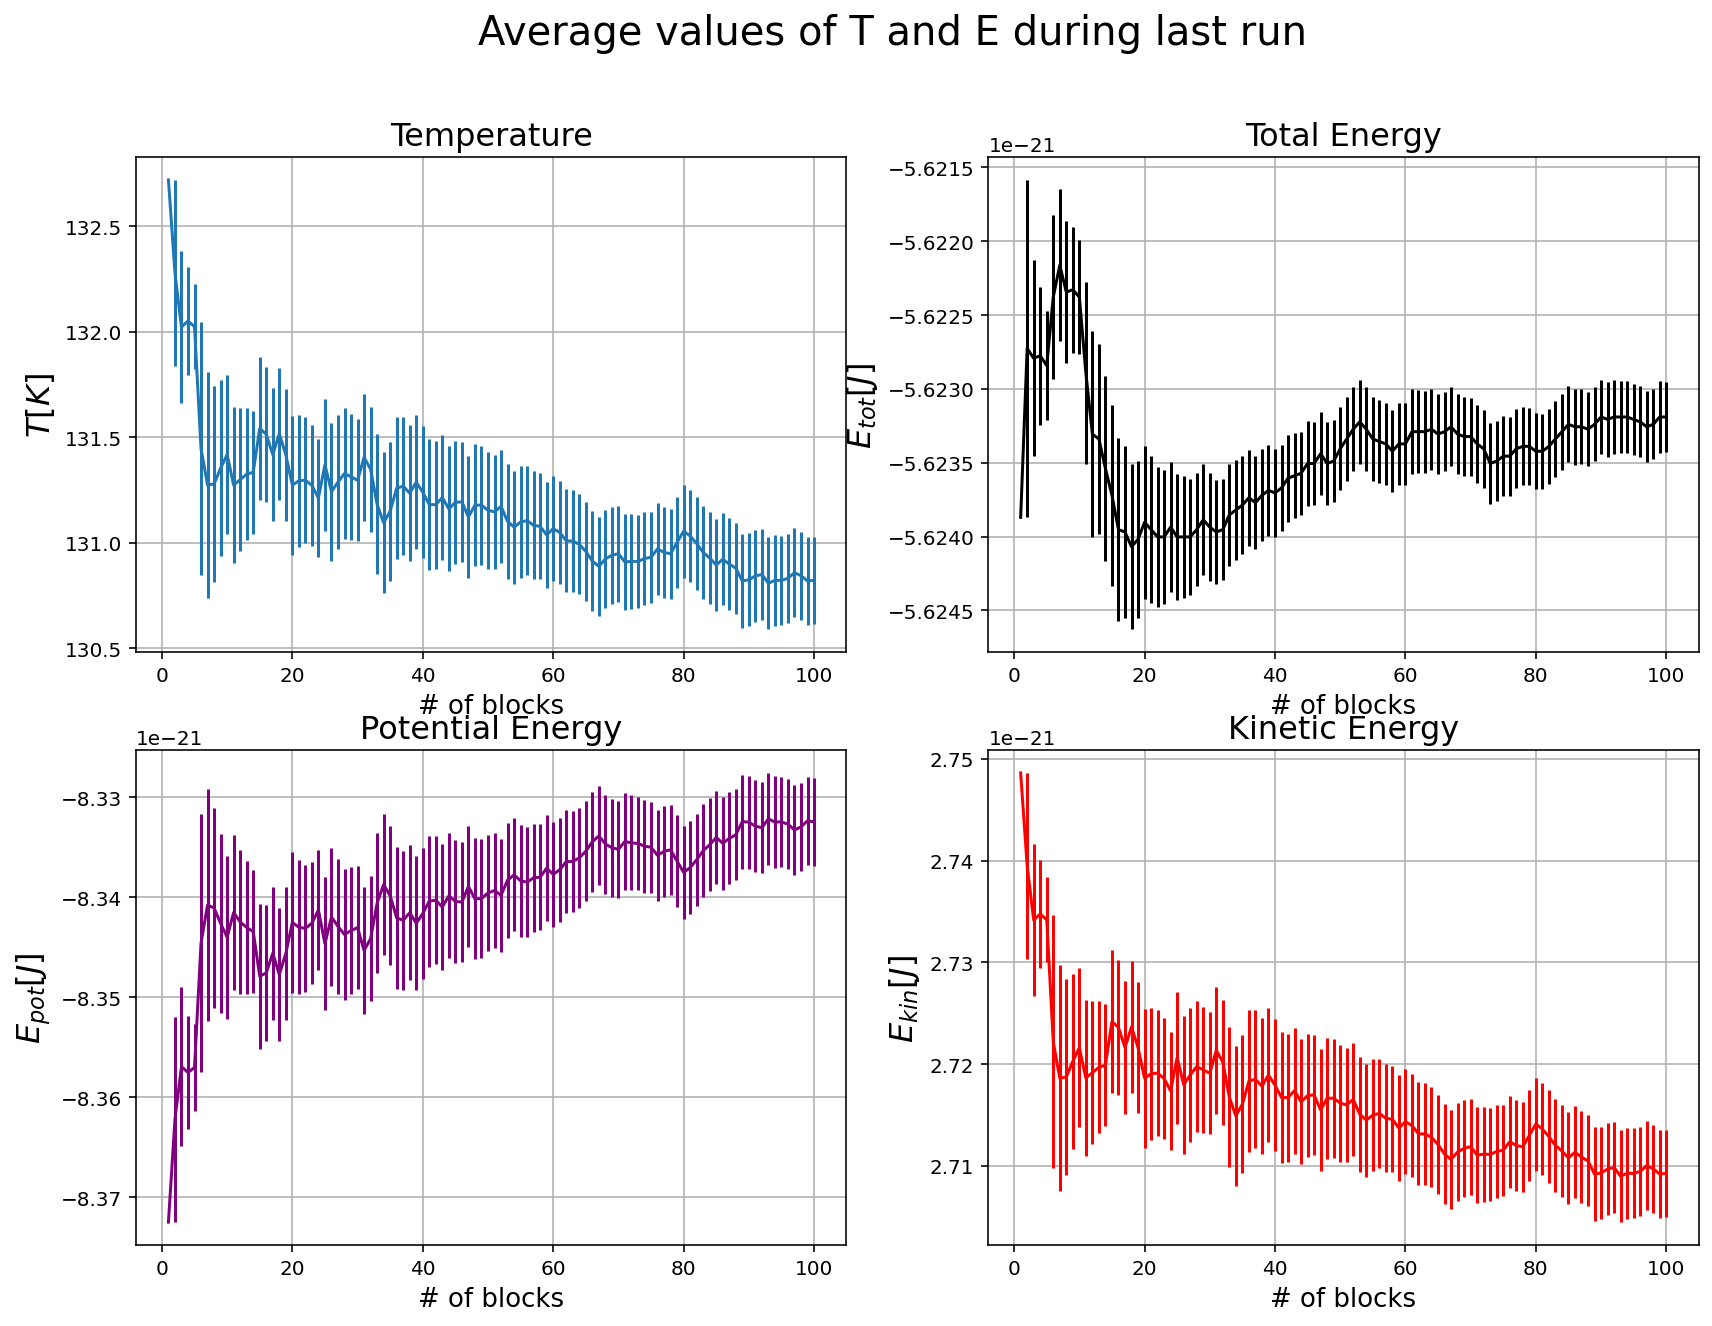

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))

(blk, Ekin, errEkin) = np.loadtxt('./04.1/MolecularDynamics_NVE/liquid_phase/ave_kin_liquid.out', unpack=True, usecols=(0,2,3))
Ekin = Ekin*epsilon
errEkin = errEkin*epsilon

(Epot, errEpot) = np.loadtxt('./04.1/MolecularDynamics_NVE/liquid_phase/ave_epot_liquid.out', unpack=True, usecols=(2,3))
Epot = Epot*epsilon
errEpot = errEpot*epsilon

(Etot, errEtot) = np.loadtxt('./04.1/MolecularDynamics_NVE/liquid_phase/ave_etot_liquid.out', unpack=True, usecols=(2,3))
Etot = Etot*epsilon
errEtot = errEtot*epsilon

(T, errT) = np.loadtxt('./04.1/MolecularDynamics_NVE/liquid_phase/ave_temp_liquid.out', unpack=True, usecols=(2,3))
T = T*epsilon_kB #SI units!!
errT = errT*epsilon_kB # also for the errors...

plt.suptitle('Average values of T and E during last run', fontsize=20)

# Temperatura
axs[0,0].set_title("Temperature", fontsize=16)
axs[0,0].errorbar(blk, T, yerr=errT, label='Temperature')
axs[0,0].set_ylabel('$T[K]$', fontsize=16)
#axs[0,0].legend(loc=1, fontsize='large')

# Energia Totale
axs[0,1].set_title("Total Energy", fontsize=16)
axs[0,1].errorbar(blk, Etot, yerr=errEtot, label='Energia totale', color='black')
axs[0,1].set_ylabel('$E_{tot}[J]$', fontsize=16)
#axs[0,1].legend(loc=1, fontsize='large')

# Energia potenziale
axs[1,0].set_title("Potential Energy", fontsize=16)
axs[1,0].errorbar(blk, Epot, yerr=errEpot, label='Energia potenziale', color='purple')
axs[1,0].set_ylabel('$E_{pot}[J]$', fontsize=16)
#axs[1,0].legend(loc=1, fontsize='large')

# Energia cinetica
axs[1,1].set_title("Kinetic Energy", fontsize=16)
axs[1,1].errorbar(blk, Ekin, yerr=errEkin, label='Energia cinetica', color='red')
axs[1,1].set_ylabel('$E_{kin} [J]$', fontsize=16)
#axs[1,1].legend(loc=1, fontsize='large')

for ax in axs.flat:
    ax.set_xlabel('# of blocks', fontsize=13)
    ax.grid()

#### FASE GASSOSA

L'equilibrazione della fase gassosa è senza dubbio la più difficile da effettuare. Il sistema non riesce a rimanere perfettamente equilibrato neanche dopo 10 ripartenze. Questo è indice del fatto che:
1. Questo codice di Dinamica Molecolare non è probabilmente molto adatto per descrivere la fase gassosa di un sistema. Questo potrebbe essere causato dal fatto che per una sostanza in fase gassoso le forze intramolecolari perdono della rilevanza che hanno invece nella fase liquida e solida. Infatti nella fase gassosa è il termine cinetico ad essere il termine più rilevante.
2. Per la stessa ragione del punto 1, considerare una configurazione FCC come configurazione iniziale del sistema perde di significato. Nella configurazione FCC sono le forza intraolecolari il termine domninate, mentre nella fase gassosa il termine principale all'energia totale è quello cinetico. Questo spiegherebbe anche l'assenza del drop iniziale alla temperatura che si osservava nell' equilibraizone della fase liquida e solida.

L'ultima ulteriore osservazione che si può fare per quanto riguarda la fase gassosa è che questa è l'unica delle tre fase che presenta un'energia totale positiva: l'Argon in fase gassosa non è in uno stato legato.

#### Equilibrazione

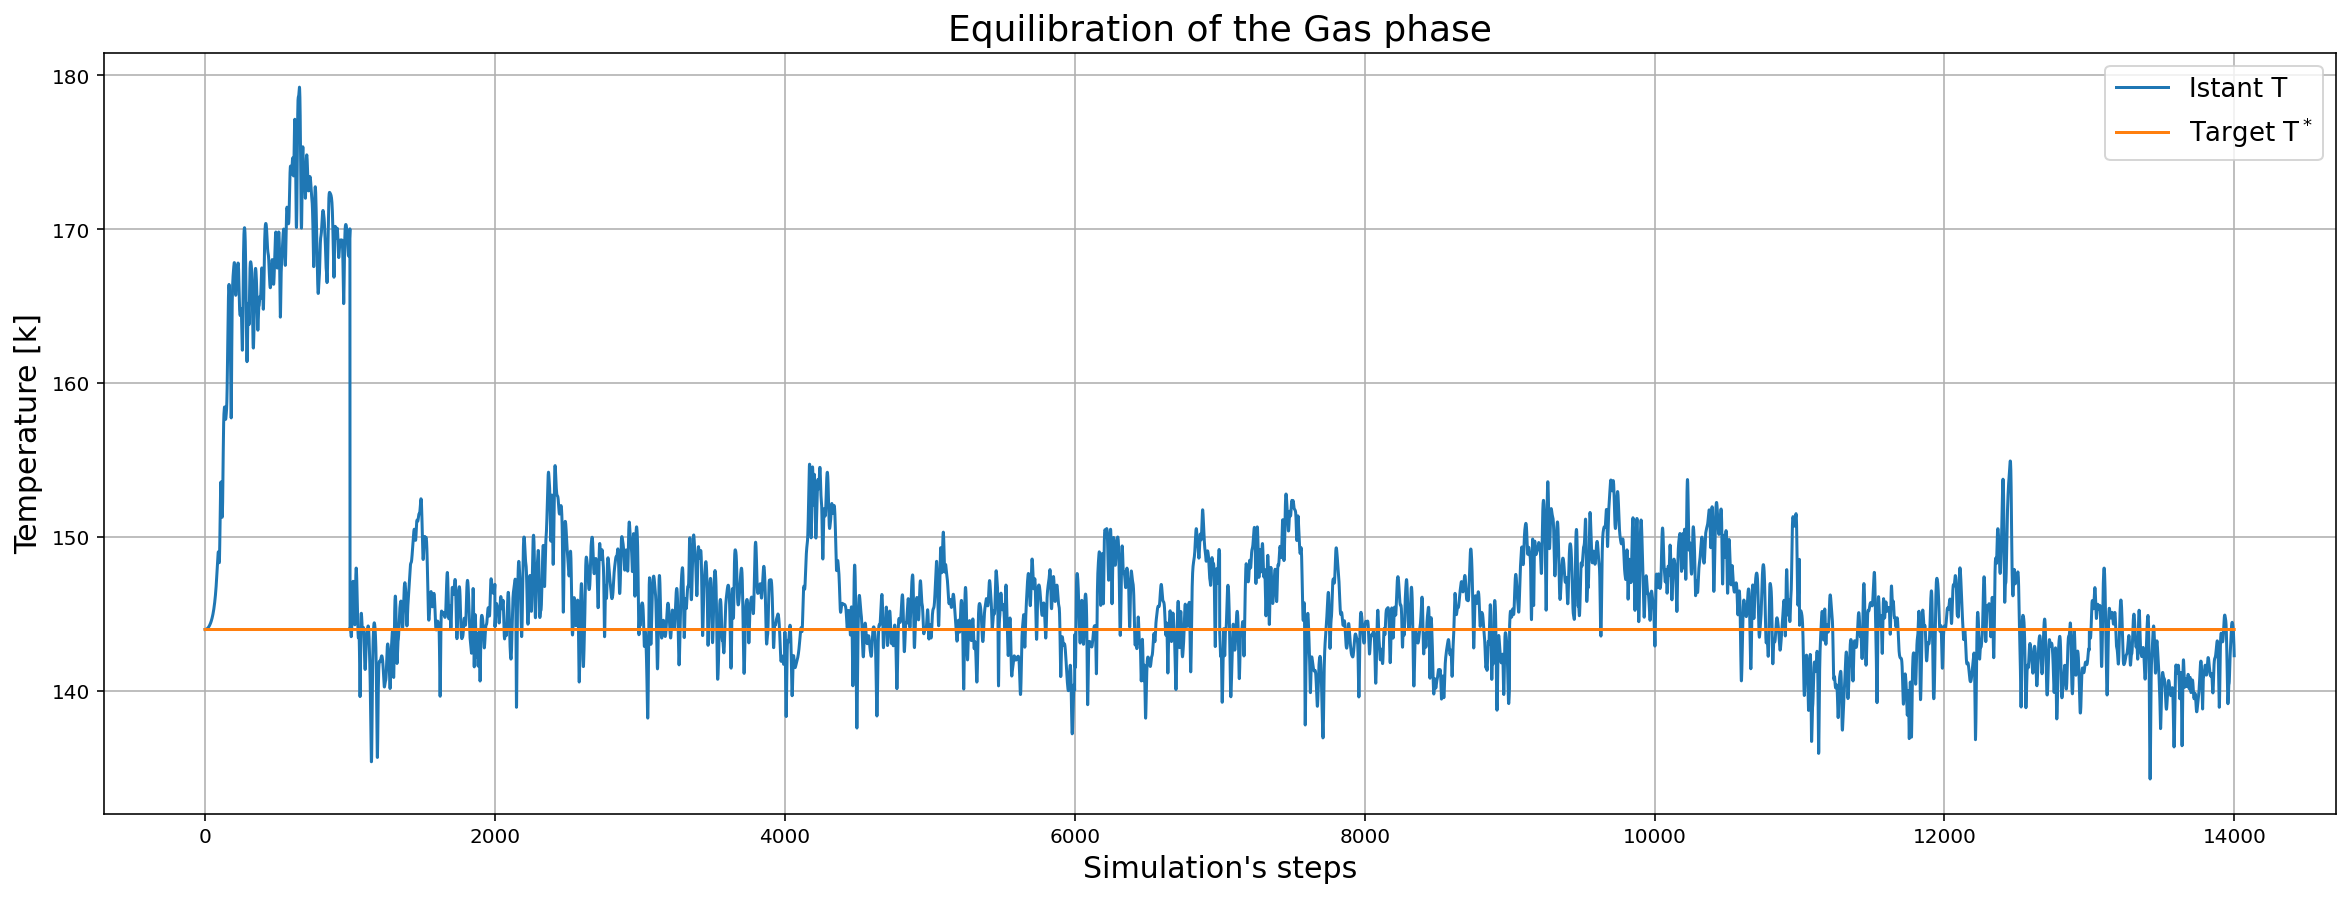

In [30]:
t = epsilon_kB*np.loadtxt("./04.1/MolecularDynamics_NVE/gas_phase/equilibration_gas.dat", usecols=(0), unpack='true')
blk=np.arange(len(t))

L = 14000
Temp=1.2

x = np.arange(L)
y=np.full(L, Temp*epsilon_kB)

plt.figure(figsize=(20,7))
plt.plot(blk,t, label='Istant T')
plt.plot(blk,y, label=r'Target T$^*$')
plt.title('Equilibration of the Gas phase', fontsize=18)
plt.ylabel('Temperature [k]', fontsize=15)
plt.xlabel("Simulation's steps", fontsize=15)

plt.legend(fontsize=13)
plt.grid()
plt.show()

#### Misure delle proprietà istantanee

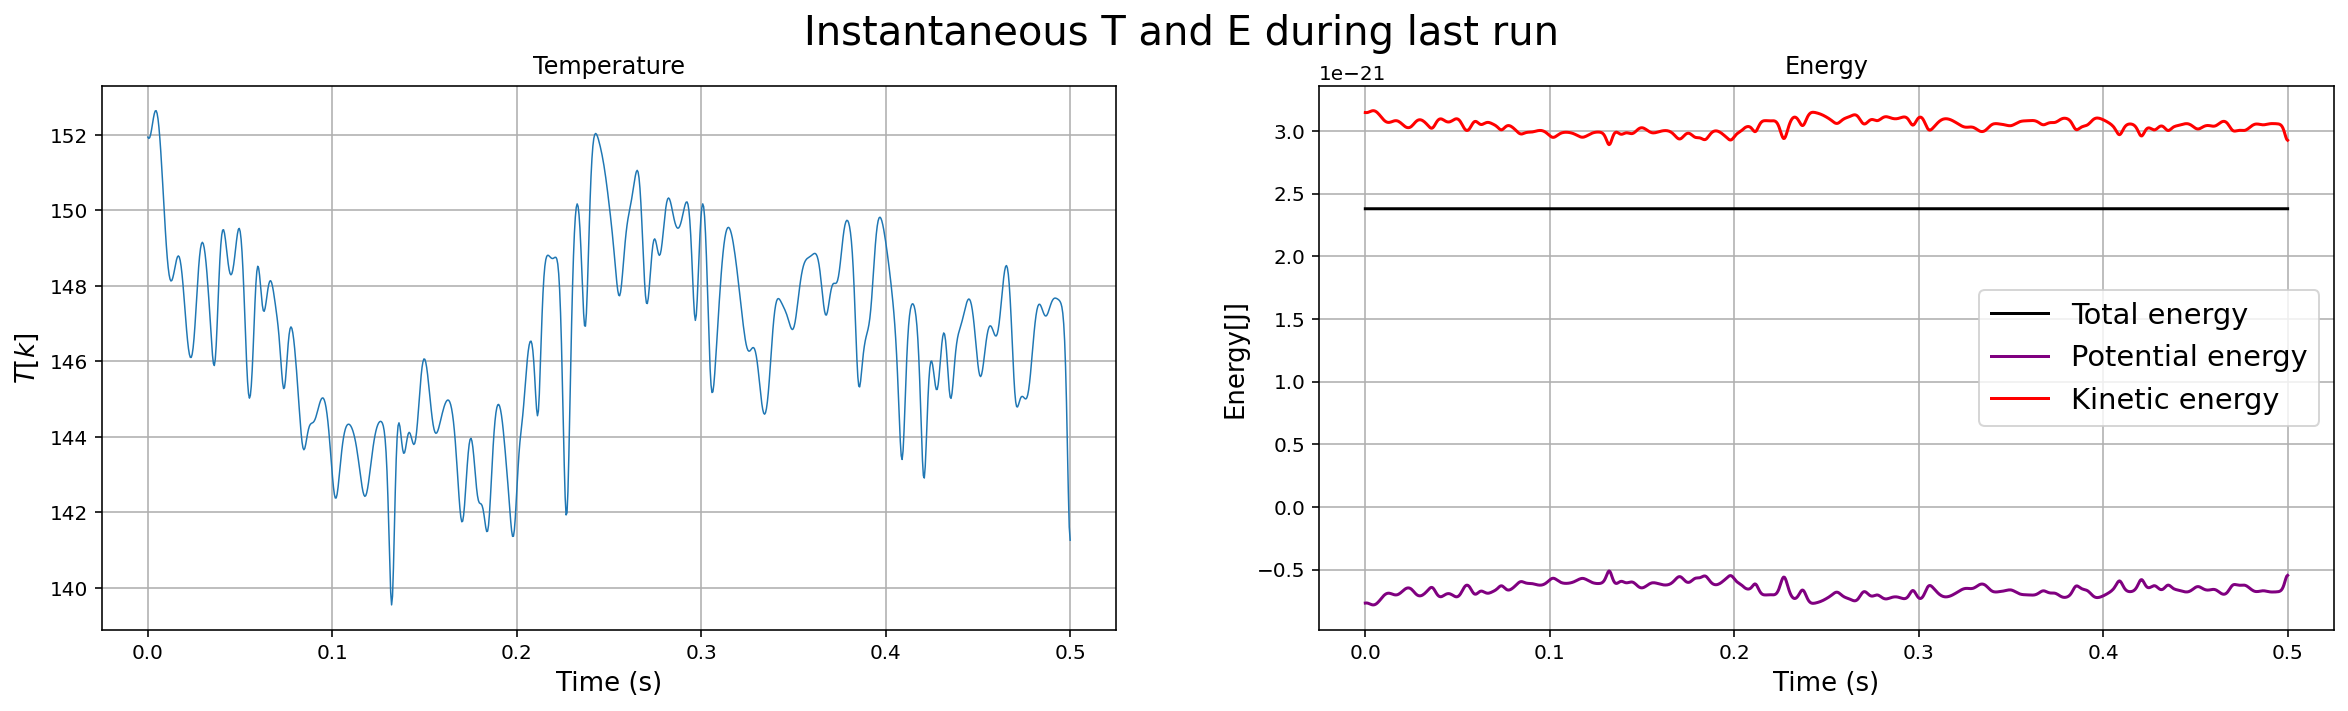

In [35]:
(T_eq) = np.loadtxt('./04.1/MolecularDynamics_NVE/gas_phase/output_temp_gas.dat', unpack=True, usecols=(0), skiprows=23000)
(Etot_eq) = np.loadtxt('./04.1/MolecularDynamics_NVE/gas_phase/output_etot_gas.dat', unpack=True, usecols=(0), skiprows=23000)
(Epot_eq) = np.loadtxt('./04.1/MolecularDynamics_NVE/gas_phase/output_epot_gas.dat', unpack=True, usecols=(0), skiprows=23000)
(Ekin_eq) = np.loadtxt('./04.1/MolecularDynamics_NVE/gas_phase/output_ekin_gas.dat', unpack=True, usecols=(0), skiprows=23000)

fig, axs = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Instantaneous T and E during last run', fontsize=20)

T_eq = T_eq*epsilon_kB #converto in SI units
l_eq = len(T_eq)
x_eq = np.linspace(0, l_eq, l_eq)

axs[0].plot(0.0005*x_eq, T_eq, linewidth=0.75)
axs[0].set_ylabel('$T[k]$', fontsize=13)
axs[0].set_title("Temperature")

axs[1].set_title("Energy")
axs[1].plot(0.0005*x_eq, Etot_eq*epsilon, label='Total energy', color='black')
axs[1].plot(0.0005*x_eq, Epot_eq*epsilon, label='Potential energy', color='purple')
axs[1].plot(0.0005*x_eq, Ekin_eq*epsilon, label='Kinetic energy', color='red')
axs[1].set_ylabel('Energy[J]', fontsize=13)
axs[1].legend(fontsize='x-large')

for ax in axs.flat:
    ax.set_xlabel('Time (s)', fontsize=13)
    ax.grid()

#### Misure delle proprietà termodinamiche a blocchi

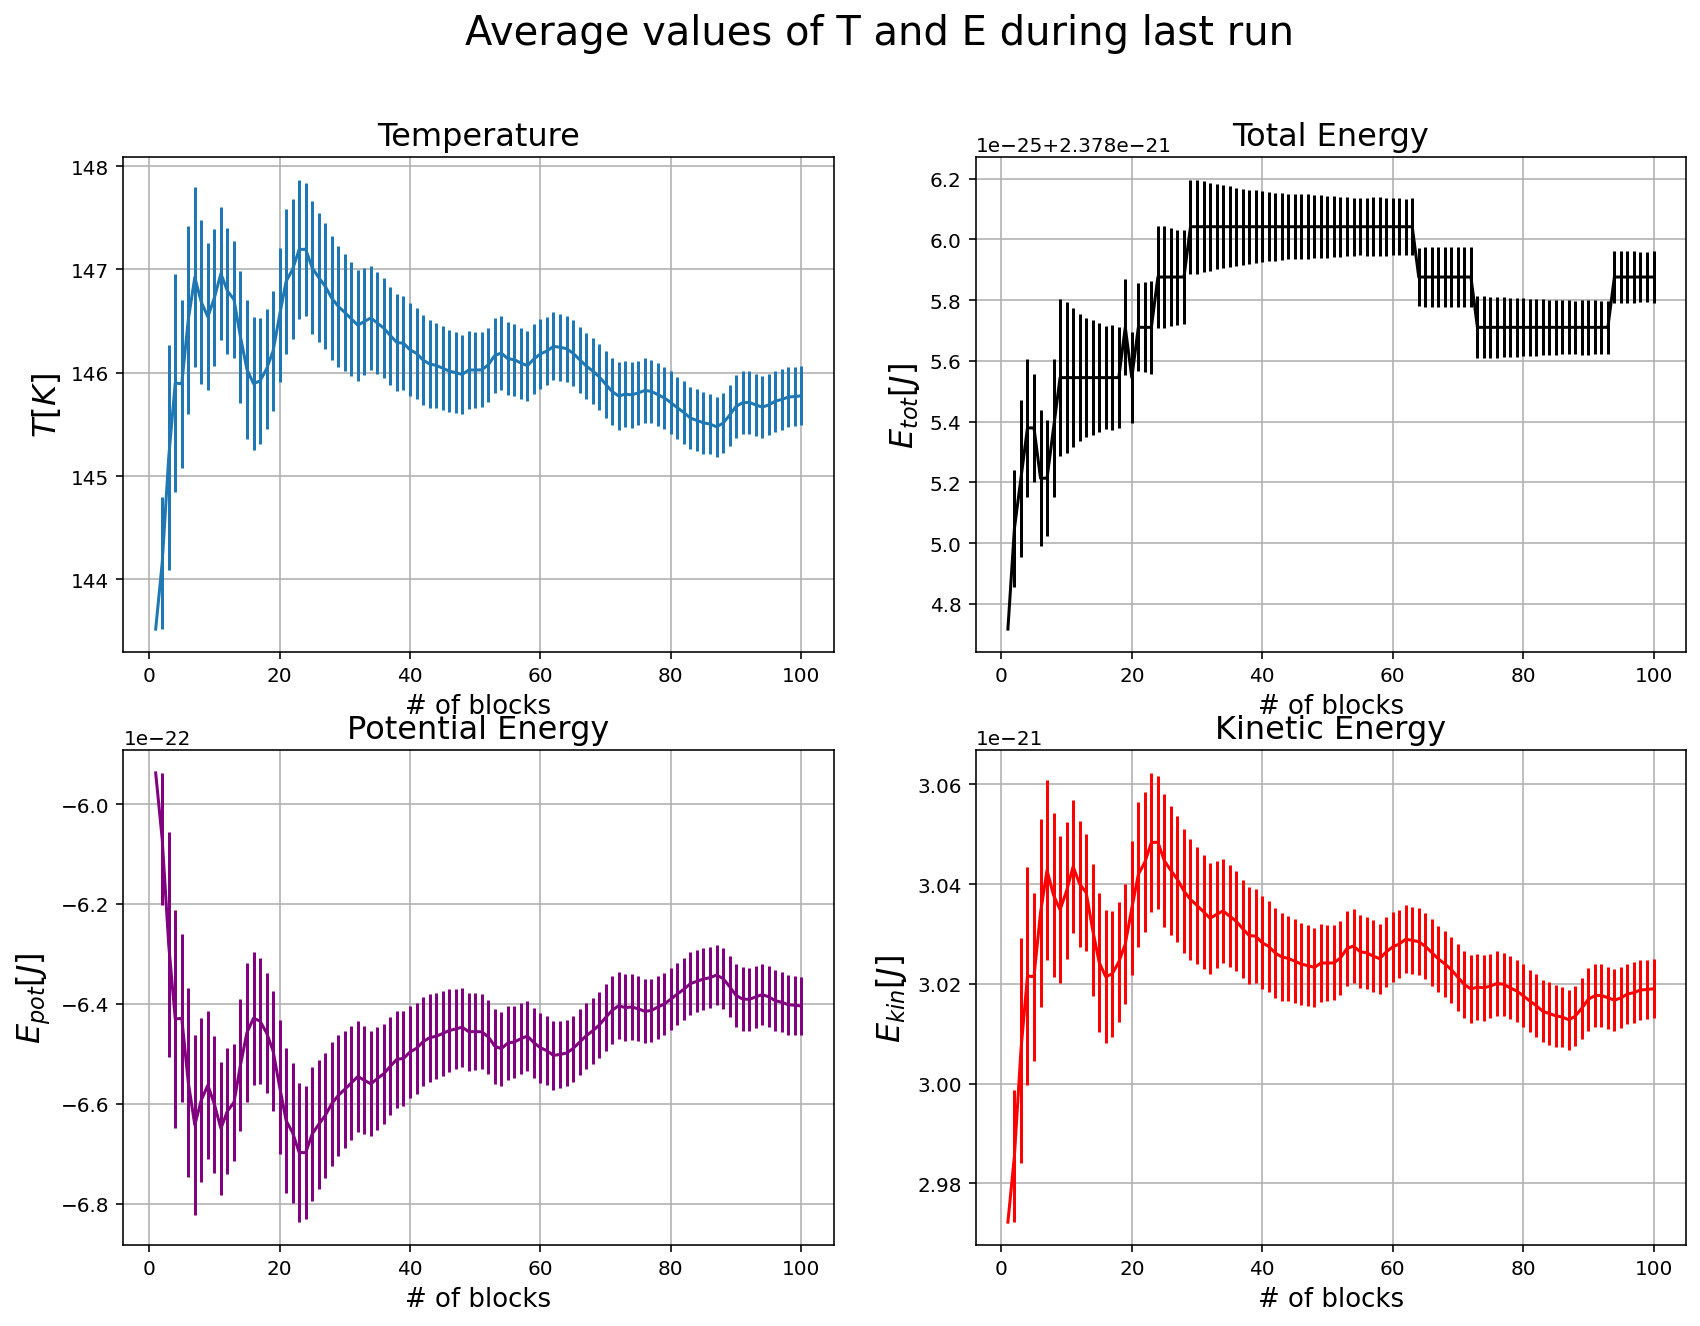

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))

(blk, Ekin, errEkin) = np.loadtxt('./04.1/MolecularDynamics_NVE/gas_phase/ave_kin_gas.out', unpack=True, usecols=(0,2,3))
Ekin = Ekin*epsilon
errEkin = errEkin*epsilon

(Epot, errEpot) = np.loadtxt('./04.1/MolecularDynamics_NVE/gas_phase/ave_epot_gas.out', unpack=True, usecols=(2,3))
Epot = Epot*epsilon
errEpot = errEpot*epsilon

(Etot, errEtot) = np.loadtxt('./04.1/MolecularDynamics_NVE/gas_phase/ave_etot_gas.out', unpack=True, usecols=(2,3))
Etot = Etot*epsilon
errEtot = errEtot*epsilon

(T, errT) = np.loadtxt('./04.1/MolecularDynamics_NVE/gas_phase/ave_temp_gas.out', unpack=True, usecols=(2,3))
T = T*epsilon_kB #SI units!!
errT = errT*epsilon_kB # also for the errors...

plt.suptitle('Average values of T and E during last run', fontsize=20)

# Temperatura
axs[0,0].set_title("Temperature", fontsize=16)
axs[0,0].errorbar(blk, T, yerr=errT, label='Temperature')
axs[0,0].set_ylabel('$T[K]$', fontsize=16)
#axs[0,0].legend(loc=1, fontsize='large')

# Energia Totale
axs[0,1].set_title("Total Energy", fontsize=16)
axs[0,1].errorbar(blk, Etot, yerr=errEtot, label='Energia totale', color='black')
axs[0,1].set_ylabel('$E_{tot}[J]$', fontsize=16)
#axs[0,1].legend(loc=1, fontsize='large')

# Energia potenziale
axs[1,0].set_title("Potential Energy", fontsize=16)
axs[1,0].errorbar(blk, Epot, yerr=errEpot, label='Energia potenziale', color='purple')
axs[1,0].set_ylabel('$E_{pot}[J]$', fontsize=16)
#axs[1,0].legend(loc=1, fontsize='large')

# Energia cinetica
axs[1,1].set_title("Kinetic Energy", fontsize=16)
axs[1,1].errorbar(blk, Ekin, yerr=errEkin, label='Energia cinetica', color='red')
axs[1,1].set_ylabel('$E_{kin} [J]$', fontsize=16)
#axs[1,1].legend(loc=1, fontsize='large')

for ax in axs.flat:
    ax.set_xlabel('# of blocks', fontsize=13)
    ax.grid()